In [1]:
## Imports
import pandas as pd
import numpy as np
import time
import findspark  # find spark home directory
import datetime
import sys
from os import chdir, getcwd, mkdir
from os.path import exists

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Print using Markdown style
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

    
    
# Import path to zipfile
ZIP_FILE = '/home/trangel/guobiao-v4/veh.zip'
sys.path.insert(0, ZIP_FILE)
from trip_based_stats.configs import *
import trip_based_stats.single_vin_battery_flow as bf


In [22]:
#vin = 'LMGFJ1S52H1000622'
#days = [datetime.date(2018,5,16), datetime.date(2018,5,17)]

#vin = 'LMGHP1S83H1000131'
#days = [datetime.date(2018,1,2)]
#days = [datetime.date(2017,12,26), datetime.date(2017,12,27)]
#days = [datetime.date(2018,3,10), datetime.date(2018,3,11)]

#vin = 'LMGHP1S58J1002212'
#days = [datetime.date(2018,4,29), datetime.date(2018,4,30)]

#vin = 'LMGHP1S80H1000149'
#days = [datetime.date(2018,3,29), datetime.date(2018,3,30)]

#vin = 'LMGHP1S88H1000111'
#days = [datetime.date(2017,12,16), datetime.date(2017,12,17)]

#vin = 'LMGHP1S80H1S00030'
#days = [datetime.date(2018,7,18)]


#vin = 'LMGHP1S83H1000131'
#days = [datetime.date(2018,4,14), datetime.date(2018,4,15)]
#days = [datetime.date(2018,6, 21), datetime.date(2018,6,22)]


#vin = 'LMGAJ1S82H1002097'
#days = [datetime.date(2018,5,18)]

vin = 'LMGHP1S5XH1000391'
days = [datetime.date(2018,1,1)]

# SOC windows for trips_full_soc and charging_full_soc
window_up_min=0
window_up_max=100
window_down_min=0
window_down_max=100
delta_soc_max=100
delta_soc_min=50

# Spark session

In [3]:
# Configure OPTIONS
findspark.init('/usr/hdp/current/spark2-client')
import pyspark
conf = pyspark.SparkConf().setAll([('spark.app.name', 'trip_stats_run'), # App Name
    ('spark.master', 'yarn'),              # spark run mode: locally or remotely
    ('spark.submit.deployMode', 'client'), # deploy in yarn-client or yarn-cluster
    ('spark.executor.memory', '8g'),       # memory allocated for each executor
    ('spark.executor.cores', '3'),         # number of cores for each executor
    ('spark.executor.instances', '1'),    # number of executors in total
    ('spark.driver.maxResultSize', '5g'), # Result size is large, need to increase from default of 1g
    ('spark.yarn.am.memory', '10g')])       # memory for spark driver (application master)
sc = pyspark.SparkContext.getOrCreate(conf=conf)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

# Load spark files and convert into pandas dataframe

In [4]:
data_files = []
for day in days:
    # Convert format
    d1 = day.isoformat()
    dd1 = d1.replace('-', '')
    # Read file
    df_name = RAW_INPUT_DIR + '/d={}'.format(dd1)
    print('DF name {}'.format(df_name))
    data_files.append(df_name)

from vehicle_utils import load_header_config

if len(data_files) == 1:
    rdd = spark.sparkContext.textFile(data_files[0])
else:
    rdds = []
    for data_file in data_files:
        rddi = spark.sparkContext.textFile(data_file)
        rdds.append(rddi)
        rdd = sc.union(rdds)


# Convert to spark df
spark_df = rdd.map(lambda x: str(x)).map(lambda w: w.split(',')).toDF()
# 2. Read header data
header_columns, configs = load_header_config(CONFIG_FILE)
spark_df = spark_df.toDF(*header_columns)

# Filter data in spark DF
df_vin = spark_df.filter("vin = '{}'".format(vin))
#df_vin.show()
# Convert to pandas
df_vin = df_vin.toPandas()
df_vin.head()

DF name hdfs://172.15.7.170:8020/data/guobiao/csv/d=20180101


,vin,vintype,ts,veh_st,veh_charge_st,veh_runmode,veh_spd,veh_odo,veh_volt,veh_curr,...,alm_others_cnt,alm_others_list,esd_volt_subsys_seq,esd_volt,esd_curr,esd_sc_cnt,esd_frame_start,esd_frame_sc_cnt,esd_sc_volt_list,esd_sc_temp_list
0,LMGHP1S5XH1000391,A5HEV,1514736075000,2,1,1,0.0,5763.0,345.0,-17.5,...,0,,,345.000,17.400,90,1,90,3.84 | 3.839 | 3.839 | 3.84 | 3.841 | 3.842 |...,7 | 8 | 8 | 9 | 9 | 9 | 9 | 10 | 11 | 11 | 11...
1,LMGHP1S5XH1000391,A5HEV,1514736105000,2,1,1,0.0,5763.0,345.0,-16.5,...,0,,,345.300,17.000,90,1,90,3.841 | 3.84 | 3.84 | 3.841 | 3.843 | 3.843 |...,7 | 7 | 7 | 9 | 9 | 9 | 9 | 10 | 11 | 11 | 11...
2,LMGHP1S5XH1000391,A5HEV,1514736145000,2,1,1,0.0,5763.0,345.0,-17.0,...,0,,,345.600,17.000,90,1,90,3.842 | 3.841 | 3.84 | 3.841 | 3.844 | 3.845 ...,7 | 7 | 7 | 9 | 9 | 9 | 9 | 10 | 11 | 11 | 11...
3,LMGHP1S5XH1000391,A5HEV,1514736215000,2,1,1,0.0,5763.0,345.0,-18.0,...,0,,,345.800,18.500,90,1,90,3.845 | 3.843 | 3.842 | 3.845 | 3.846 | 3.847...,7 | 7 | 7 | 9 | 9 | 9 | 9 | 10 | 11 | 11 | 10...
4,LMGHP1S5XH1000391,A5HEV,1514736295000,2,1,1,0.0,5763.0,345.0,-19.5,...,0,,,345.800,19.600,90,1,90,3.848 | 3.847 | 3.846 | 3.849 | 3.849 | 3.85 ...,6 | 7 | 7 | 8 | 9 | 9 | 9 | 10 | 11 | 11 | 11...


# Battery flow for a single VIN

In [23]:
reload(bf)
flow = bf.single_vin_battery_flow(
    df=df_vin, vin=vin, end_date=day,
    window_up_min=window_up_min,
    window_up_max=window_up_max,
    window_down_min=window_down_min,
    window_down_max=window_down_max,
    delta_soc_max=delta_soc_max,
    delta_soc_min=delta_soc_min
)

flow.show()

# Convert to series for plotting
# Convert to time series to plot
ts = flow.df
ts.index = ts['ts']
ts_charge = flow.df_charge
ts_charge.index = ts_charge['ts']
ts_drive = flow.df_drive
ts_drive.index = ts_drive['ts']
ts_drive_on_batt = flow.df_drive_on_batt
ts_drive_on_batt.index = ts_drive_on_batt['ts']

               '2018-01-01 00:00:25+08:00', '2018-01-01 00:00:45+08:00',
               '2018-01-01 00:00:55+08:00', '2018-01-01 00:01:05+08:00',
               '2018-01-01 00:01:15+08:00', '2018-01-01 00:01:25+08:00',
               '2018-01-01 00:01:35+08:00', '2018-01-01 00:01:45+08:00',
               ...
               '2018-01-01 23:57:45+08:00', '2018-01-01 23:57:55+08:00',
               '2018-01-01 23:58:05+08:00', '2018-01-01 23:58:15+08:00',
               '2018-01-01 23:58:45+08:00', '2018-01-01 23:58:55+08:00',
               '2018-01-01 23:59:25+08:00', '2018-01-01 23:59:35+08:00',
               '2018-01-01 23:59:45+08:00', '2018-01-01 23:59:55+08:00'],
              dtype='datetime64[ns, Asia/Hong_Kong]', name=u'ts', length=6158, freq=None)
N 6158
Nc 2419
Nd 2008
Ndb 2008
VIN number LMGHP1S5XH1000391
End date 2018-01-01
Dataset size 6158
SOC windows:

	window_up_min 0
	window_up_max 100
	window_down_min 0
	window_down_max 100
	delta_soc_min 50
	delta_soc_max 100


# Charging and driving records

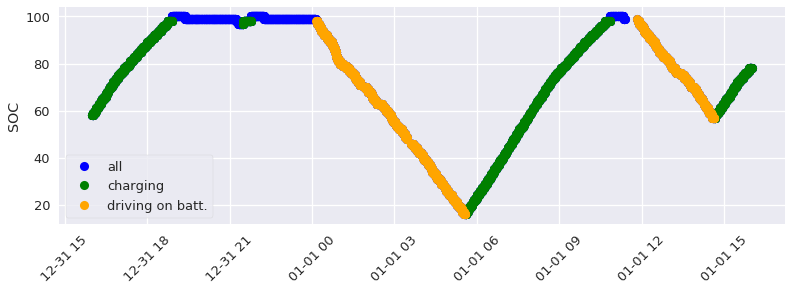

In [24]:
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')


f, (ax) = plt.subplots()

ax.plot(ts['veh_soc'], 'bo', label='all')
#ax.plot(ts_drive['veh_soc'], 'ro', label='driving')
ax.plot(ts_charge['veh_soc'], 'go', label='charging')
ax.plot(ts_drive_on_batt['veh_soc'], 'o', color='orange', label='driving on batt.')
#ax.plot(ts2['veh_soc'], 'ro')

ax.legend(loc=0, frameon=True)
ax.set_ylabel('SOC')
plt.xticks(rotation=45)
sns.despine()

# Trips and charging periods

In [25]:
flow.battery_periods()

Found 2 driving periods
Found 3 charging periods
Found 1 charging full-soc periods
Found 1 trips full-soc


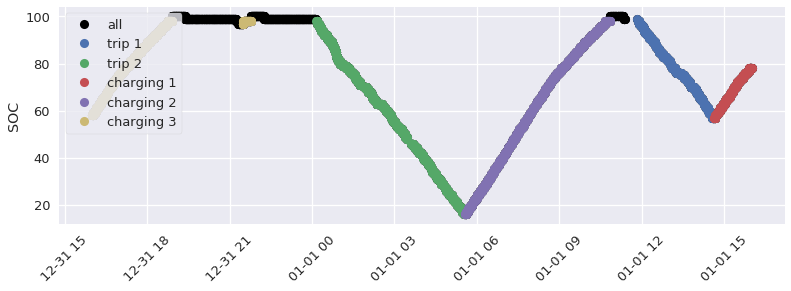

In [26]:
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')


f, (ax) = plt.subplots()

ax.plot(ts['veh_soc'], 'o', color='black', label='all')
for i, df in enumerate(flow.trips_on_battery):
    ax.plot(df['veh_soc'], 'o', label='trip {}'.format(i+1))
      
for i, df in enumerate(flow.charging_periods):
    ax.plot(df['veh_soc'], 'o',  label='charging {}'.format(i+1))

ax.legend(loc=2, frameon=True)
ax.set_ylabel('SOC')
plt.xticks(rotation=45)
sns.despine()

# Trips and charging full SOC

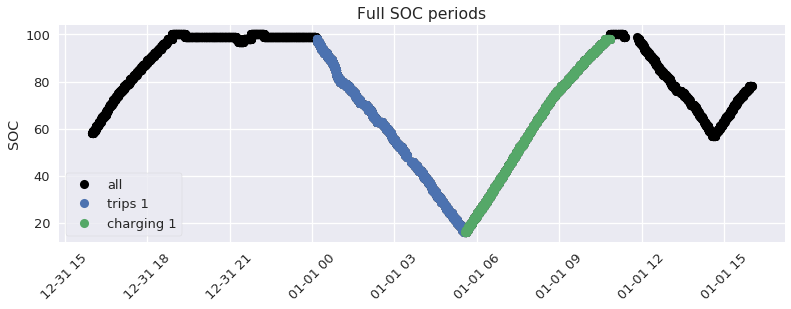

In [27]:
sns.set(rc={"figure.figsize": (13, 4)})
sns.set_context('talk')


f, (ax) = plt.subplots()

ax.plot(ts['veh_soc'], 'o', color='black', label='all')
for i, df in enumerate(flow.trips_full_soc):
    ax.plot(df['veh_soc'], 'o', label='trips {}'.format(i+1))
for i, df in enumerate(flow.charging_full_soc_periods):
    ax.plot(df['veh_soc'], 'o',  label='charging {}'.format(i+1))

ax.set_title('Full SOC periods')
ax.legend(loc=0, frameon=True)
ax.set_ylabel('SOC')
plt.xticks(rotation=45)
sns.despine()

# Statistics   

In [28]:
# which stats = 1: charging, 2: charging full-soc, 3: driving, 4: driving full-soc, 5: polarization
stats = flow.get_battery_stats(which_stats=2)
stats = pd.DataFrame(stats)
print('Stats for {}\n{}'.format(vin, ' '.join(stats.columns)))
print(len(stats.columns))

# Select some columns to visualize
#stats[['day', 'normalized_ah_consumption', 'start_time', 'end_time', 'normalized_kwh_consumption', 'odometer_offset', 'count_records', 'duration', 'delta_soc']].head()#
stats[['day', 'normalized_ah_throughput', 'normalized_kwh_throughput', 'start_time', 'end_time', 'count_records', 'duration', 'delta_soc']].head()



Stats for LMGHP1S5XH1000391
ah_throughput battery_temp_avg battery_temp_max battery_temp_min cell_volt_avg_mean cell_volt_avg_p1 cell_volt_avg_p99 cell_volt_avg_std cell_volt_diff_mean cell_volt_diff_p1 cell_volt_diff_p99 cell_volt_diff_std count_records day delta_soc duration end_soc end_time kwh_throughput normalized_ah_throughput normalized_duration normalized_kwh_throughput start_soc start_time veh_curr_mean veh_curr_p1 veh_curr_p99 veh_curr_std
28


,day,normalized_ah_throughput,normalized_kwh_throughput,start_time,end_time,count_records,duration,delta_soc
0,2018-01-01,104.728064,36.196796,2018-01-01 13:34:55+08:00,2018-01-01 18:50:35+08:00,1129,5.261111,82


In [36]:
import trip_based_stats.battery_stats as battery_stats
import common.missing_data as md

def print_ct(x):
    print( 'Ah charged {}, discharged {}, throughput {}, consumption {}'.format(x[0], x[1], x[2], x[3]))
    y = x / delta_soc * 100
    print( 'Normalized Ah charged {}, discharged {}, throughput {}, consumption {}'.format(y[0], y[1], y[2], y[3]))

    
period_index = 0
df = flow.charging_full_soc_periods[period_index]
#df = flow.charging_periods[period_index]
#df = flow.trips_full_soc[period_index]
# Make sure stats above is for charging_full_soc or trips_full_soc, consistent with this
delta_soc = np.absolute(stats.loc[period_index, 'delta_soc'])


# For trips
#negative_slope=True
#slope_limit = -0.0005
# For charging
negative_slope=False
slope_limit = 0.001

cols = ['ts', 'veh_curr', 'veh_volt', 'veh_soc']
df2 = df[cols].copy()

# Remove 0.0 entries
df2 = df2.query('veh_curr != 0').copy()

printmd('# vin {}, day {}'.format(vin, day))
printmd('## No corrections')
printmd('** Integration by sum, without correction **')
x_by_sum = battery_stats.get_energy_n_capacity_bysum(df2, option=4)
print_ct(x_by_sum)

printmd('## Compensating missing SOC')
printmd('** Integration by sum, compensate missing SOC **')
compensated = md.compensate_missing_soc(df2['veh_soc'], x_by_sum)
print_ct(compensated)
          
printmd('## Compensating missing time with fixed offset of 120s')
df3 = md.treat_missing_data(df2, offset_seconds=120,
slope_limit=slope_limit, negative_slope=negative_slope)
real_duration = df3.index[-1]
data_duration = len(df2) * 10
# Note df3 has corrected time index, df2 is the original dataset without corrections
print('Total duration {}s with missing time (jumps) {}s'.format(real_duration, real_duration - data_duration))          

printmd('** Integration by sum, compensate missing time, fixed offset **')
compensated = md.compensate_missing_data(real_duration, data_duration, x_by_sum)
print_ct(compensated)
printmd('** Integration by quadrature and interpolate missing data, fixed offset **')
x_by_int = battery_stats.get_energy_n_capacity(df3, option=4)
print_ct(x_by_int)

printmd('## Compensating missing time with current-dependent threshold')
df3 = md.treat_missing_data_current_dependent_threshold(df2, threshold_factor=2.5,
        negative_slope=negative_slope)

real_duration = df3.index[-1]
data_duration = len(df2) * 10
# Note df3 has corrected time index, df2 is the original dataset without corrections
print('Total duration {}s with missing time (jumps) {}s'.format(real_duration, real_duration - data_duration))          

printmd('** Integration by sum, compensate missing time, current-dependent threshold **')
compensated = md.compensate_missing_data(real_duration, data_duration, x_by_sum)

print_ct(compensated)
printmd('** Integration by quadrature and interpolate missing data, current-dependent threshold **')
x_by_int = battery_stats.get_energy_n_capacity(df3, option=4)
print_ct(x_by_int)



# vin LMGHP1S5XH1000391, day 2018-01-01

## No corrections

** Integration by sum, without correction **

Ah charged 52.0986111111, discharged 0.0, throughput 52.0986111111, consumption -52.0986111111
Normalized Ah charged 63.5348915989, discharged 0.0, throughput 63.5348915989, consumption -63.5348915989


## Compensating missing SOC

** Integration by sum, compensate missing SOC **

    Delta SOC 82
    Missing SOC 0.0
    Actual delta SOC 82.0
    Compensation factor 1.0
Ah charged 52.0986111111, discharged 0.0, throughput 52.0986111111, consumption -52.0986111111
Normalized Ah charged 63.5348915989, discharged 0.0, throughput 63.5348915989, consumption -63.5348915989


## Compensating missing time with fixed offset of 120s

Total duration 18940s with missing time (jumps) 7650s


** Integration by sum, compensate missing time, fixed offset **

Ah charged 87.4001500837, discharged 0.0, throughput 87.4001500837, consumption -87.4001500837
Normalized Ah charged 106.585548883, discharged 0.0, throughput 106.585548883, consumption -106.585548883


** Integration by quadrature and interpolate missing data, fixed offset **

Ah charged 85.8770131782, discharged 0.0, throughput 85.8770131782, consumption -85.8770131782
Normalized Ah charged 104.728064851, discharged 0.0, throughput 104.728064851, consumption -104.728064851


## Compensating missing time with current-dependent threshold

Total duration 18940s with missing time (jumps) 7650s


** Integration by sum, compensate missing time, current-dependent threshold **

Ah charged 87.4001500837, discharged 0.0, throughput 87.4001500837, consumption -87.4001500837
Normalized Ah charged 106.585548883, discharged 0.0, throughput 106.585548883, consumption -106.585548883


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 85.8770131782, discharged 0.0, throughput 85.8770131782, consumption -85.8770131782
Normalized Ah charged 104.728064851, discharged 0.0, throughput 104.728064851, consumption -104.728064851


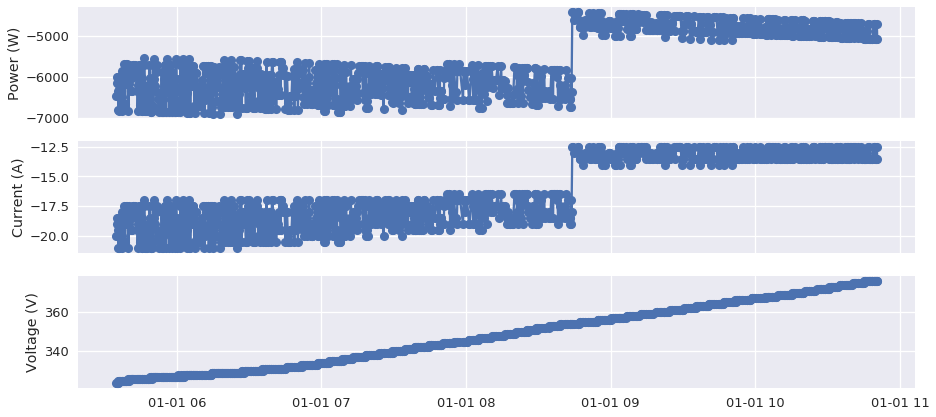

In [30]:
sns.set(rc={"figure.figsize": (15, 7)})
sns.set_context('talk')

df2['power'] = df2['veh_curr'] * df2['veh_volt']


fig, ax = plt.subplots(3)

ax[0].plot(df2['power'], 'o-')
ax[1].plot(df2['veh_curr'], 'o-')
ax[2].plot(df2['veh_volt'], 'o-')


ax[0].set_ylabel('Power (W)')
ax[1].set_ylabel('Current (A)')
ax[2].set_ylabel('Voltage (V)')

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

sns.despine()


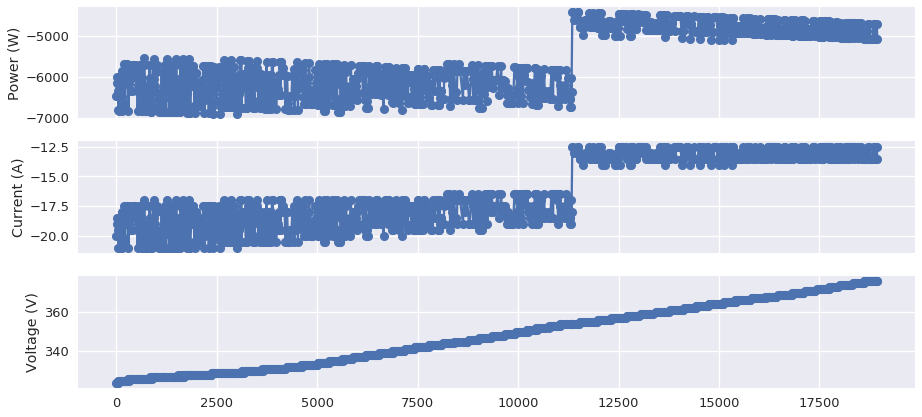

In [31]:
sns.set(rc={"figure.figsize": (15, 7)})
sns.set_context('talk')

df3['power'] = df3['veh_curr'] * df3['veh_volt']


fig, ax = plt.subplots(3)

ax[0].plot(df3['power'], 'o-')
ax[1].plot(df3['veh_curr'], 'o-')
ax[2].plot(df3['veh_volt'], 'o-')


ax[0].set_ylabel('Power (W)')
ax[1].set_ylabel('Current (A)')
ax[2].set_ylabel('Voltage (V)')

plt.setp(ax[0].get_xticklabels(), visible=False)
plt.setp(ax[1].get_xticklabels(), visible=False)

sns.despine()

In [15]:
# Close session
sc.stop()

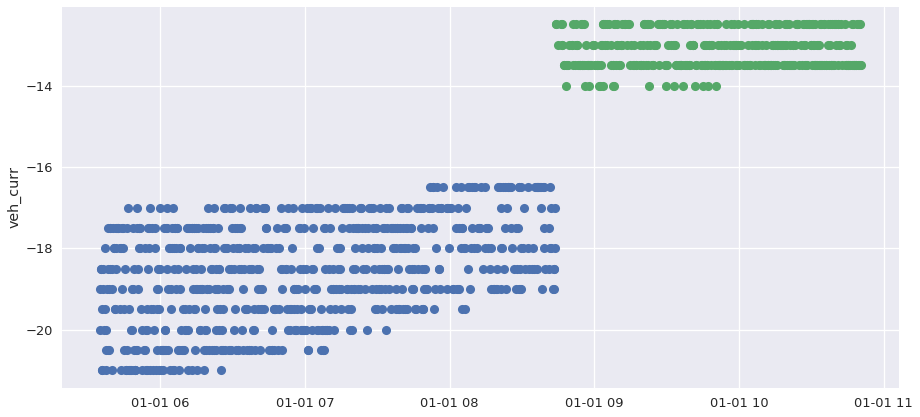

In [122]:
df = flow.charging_full_soc_periods[0]
curr = df.veh_curr.values
ijump = np.argmax(np.abs(np.diff(curr)) > 5) + 1
df1 = df[ijump:]
df2 = df[:ijump]

sns.set(rc={"figure.figsize": (15, 7)})
sns.set_context('talk')

fig, ax = plt.subplots()

ax.plot(df1['veh_curr'], 'o')
ax.plot(df2['veh_curr'], 'o')
ax.set_ylabel('veh_curr')

sns.despine()

In [116]:
def get_ah(df):

    # For trips
    #negative_slope=True
    #slope_limit = -0.0005
    # For charging
    negative_slope=False
    slope_limit = 0.001
    
    delta_soc = df.veh_soc.max() - df.veh_soc.min()


    cols = ['ts', 'veh_curr', 'veh_volt', 'veh_soc']
    df2 = df[cols].copy()

    # Remove 0.0 entries
    df2 = df2.query('veh_curr != 0').copy()

    printmd('## Compensating missing time with current-dependent threshold')
    df3 = md.treat_missing_data_current_dependent_threshold(df2, threshold_factor=10,
        negative_slope=negative_slope)

    real_duration = df3.index[-1]
    data_duration = len(df2) * 10
    # Note df3 has corrected time index, df2 is the original dataset without corrections
    print('Total duration {}s with missing time (jumps) {}s'.format(real_duration, real_duration - data_duration))          

    printmd('** Integration by quadrature and interpolate missing data, current-dependent threshold **')
    x_by_int = battery_stats.get_energy_n_capacity(df3, option=4)
    print_ct(x_by_int)
    
    ah_throughput = x_by_int[2]
    return delta_soc, ah_throughput


In [117]:
df1_ = df1.copy()
df2_ = df2.copy()
df1_['veh_curr'] = df1['veh_curr'].mean()
delta_soc1, ah1 = get_ah(df1_)

df2_['veh_curr'] = df2['veh_curr'].mean()
delta_soc2, ah2 = get_ah(df2_)

delta_soc = delta_soc1 + delta_soc2
ah = ah1 + ah2
ah * 100 / delta_soc

## Compensating missing time with current-dependent threshold

Total duration 11330s with missing time (jumps) 4100s


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 58.4652028585, discharged 0.0, throughput 58.4652028585, consumption -58.4652028585
Normalized Ah charged 71.2990278762, discharged 0.0, throughput 71.2990278762, consumption -71.2990278762


## Compensating missing time with current-dependent threshold

Total duration 7590s with missing time (jumps) 3530s


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 27.6498050082, discharged 0.0, throughput 27.6498050082, consumption -27.6498050082
Normalized Ah charged 33.7192744003, discharged 0.0, throughput 33.7192744003, consumption -33.7192744003


105.0183022764272

In [118]:
# Remove lower end  & higher end
min_soc = df1.veh_soc.min()
df1_ = df1.query('veh_soc > {}'.format(min_soc)).copy()
delta_soc1, ah1 = get_ah(df1_)

max_soc = df2.veh_soc.max()
df2_ = df2.query('veh_soc < {}'.format(max_soc)).copy()
delta_soc2, ah2 = get_ah(df2_)

delta_soc = delta_soc1 + delta_soc2
ah = ah1 + ah2
ah * 100 / delta_soc

## Compensating missing time with current-dependent threshold

Total duration 11200s with missing time (jumps) 4080s


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 57.3619776733, discharged 0.0, throughput 57.3619776733, consumption -57.3619776733
Normalized Ah charged 69.9536313089, discharged 0.0, throughput 69.9536313089, consumption -69.9536313089


## Compensating missing time with current-dependent threshold

Total duration 6940s with missing time (jumps) 3250s


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 25.2673362921, discharged 0.0, throughput 25.2673362921, consumption -25.2673362921
Normalized Ah charged 30.8138247465, discharged 0.0, throughput 30.8138247465, consumption -30.8138247465


103.28664245680645

In [119]:
from scipy.optimize import curve_fit

def f(x, A, B): # this is your 'straight line' y=f(x)
    return A * x + B

def get_ah_line(df):

    # For trips
    #negative_slope=True
    #slope_limit = -0.0005
    # For charging
    negative_slope=False
    slope_limit = 0.001
    
    delta_soc = df.veh_soc.max() - df.veh_soc.min()


    cols = ['ts', 'veh_curr', 'veh_volt', 'veh_soc']
    df2 = df[cols].copy()

    # Remove 0.0 entries
    df2 = df2.query('veh_curr != 0').copy()

    printmd('## Compensating missing time with current-dependent threshold')
    df3 = md.treat_missing_data_current_dependent_threshold(df2, threshold_factor=10,
        negative_slope=negative_slope)

    x = df3.index.values
    y = df3.veh_curr.values
    popt, pcov = curve_fit(f, x, y)
    veh_curr = x * popt[0] + popt[1]
    df3['veh_curr'] = veh_curr
    
    real_duration = df3.index[-1]
    data_duration = len(df2) * 10
    # Note df3 has corrected time index, df2 is the original dataset without corrections
    print('Total duration {}s with missing time (jumps) {}s'.format(real_duration, real_duration - data_duration))          

    printmd('** Integration by quadrature and interpolate missing data, current-dependent threshold **')
    x_by_int = battery_stats.get_energy_n_capacity(df3, option=4)
    print_ct(x_by_int)
    
    ah_throughput = x_by_int[2]
    return delta_soc, ah_throughput, df3

In [120]:
def get_ts(df):
    cols = ['ts', 'veh_curr', 'veh_volt', 'veh_soc']
    df2 = df[cols].copy()

    # Remove 0.0 entries
    df2 = df2.query('veh_curr != 0').copy()

    printmd('## Compensating missing time with current-dependent threshold')
    df3 = md.treat_missing_data_current_dependent_threshold(df2, threshold_factor=10,
        negative_slope=negative_slope)

    return df3

df1a = get_ts(df1)
df2a = get_ts(df2)

df1_ = df1.copy()
df2_ = df2.copy()
delta_soc1, ah1, df1_ = get_ah_line(df1_)

delta_soc2, ah2, df2_ = get_ah_line(df2_)

delta_soc = delta_soc1 + delta_soc2
ah = ah1 + ah2
ah * 100 / delta_soc

## Compensating missing time with current-dependent threshold

## Compensating missing time with current-dependent threshold

## Compensating missing time with current-dependent threshold

Total duration 11330s with missing time (jumps) 4100s


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 58.1598898249, discharged 0.0, throughput 58.1598898249, consumption -58.1598898249
Normalized Ah charged 72.6998622811, discharged 0.0, throughput 72.6998622811, consumption -72.6998622811


## Compensating missing time with current-dependent threshold

Total duration 7590s with missing time (jumps) 3530s


** Integration by quadrature and interpolate missing data, current-dependent threshold **

Ah charged 27.6553172402, discharged 0.0, throughput 27.6553172402, consumption -27.6553172402
Normalized Ah charged 34.5691465503, discharged 0.0, throughput 34.5691465503, consumption -34.5691465503


104.65269154279268

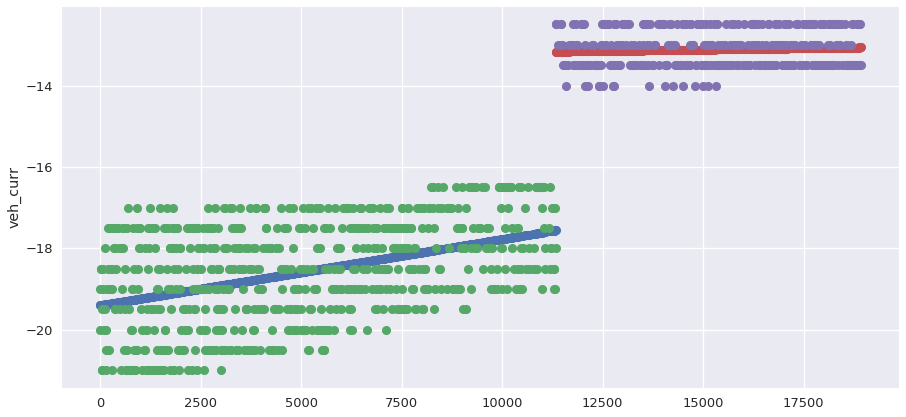

In [123]:
sns.set(rc={"figure.figsize": (15, 7)})
sns.set_context('talk')

fig, ax = plt.subplots()

last_i1 = df1_.index[-1]

ax.plot(df1_['veh_curr'], 'o')
ax.plot(df1a['veh_curr'], 'o')
ax.plot(df2_.index + last_i1, df2_['veh_curr'], 'o')
ax.plot(df2a.index + last_i1, df2a['veh_curr'], 'o')
ax.set_ylabel('veh_curr')
sns.despine()